In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize

from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [3]:
data = loadmat('data/ex3data1.mat')

y = data['y']
X = np.c_[np.ones((data["X"].shape[0], 1)), data['X']]        # generates 5000x401 array

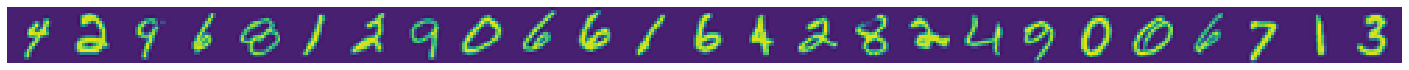

In [4]:
numbers = np.random.choice(X.shape[0], 25)
fig, ax = plt.subplots(1, figsize=(25,25))
plt.imshow(X[numbers, 1:].reshape(-1,20).T)
plt.axis('off');
plt.show()

In [5]:
def sigmoid(z):
    sigmoid = 1 / (1 + np.exp(-z))
    return sigmoid

In [6]:
EPSILON = 1e-10

def reg_cost_function_lr(theta, reg, *args):
    m = y.size
    h = sigmoid(X @ theta.reshape(-1,1))
    
    regularisation = (reg / (2 * m)) * np.sum(np.square(theta[1:]))
    
    J = -1 * (1 / m) * ((y) @ np.log(h + EPSILON).T + (1 - y) @ np.log(1 - h + EPSILON).T) + regularisation
    return(J[0])

In [7]:
def reg_gradient_lr(theta, reg, *args):
    m = y.size
    h = sigmoid(X @ theta.reshape(-1,1))
      
    grad = (1/m) * X.T @ (h-y) + (reg / m) * np.r_[[[0]], theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [8]:
def one_vs_all(X, y, reg):
    n = X.shape[1]
    classes = np.unique(y)
    no_of_labels = classes.shape[0]
    
    initial_thetas = np.zeros((n, 1))
    all_thetas = np.zeros((no_of_labels, n))
    
    for class_ in classes:
        print(class_)
        res = minimize(reg_cost_function_lr,
                       initial_thetas,
                       args=(reg, X, np.int_(y == class_)),
                       method=None,
                       jac=reg_gradient_lr,
                       options={'maxiter':100000})
        #print(res.x.reshape(-1, 1).shape[:], all_thetas[:, class_ - 1].shape[:])
        #print(res.x[:50])
        #print((y == class_)[500:550])
        all_thetas[class_ - 1] = res.x
    
    return all_thetas

In [9]:
X.shape[:]

(5000, 401)

In [11]:
all_thetas = one_vs_all(X, y, 0.1)

1


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
all_thetas[5, :]

In [ ]:
def predictOneVsAll(all_thetas, features):
    probs = sigmoid(X.dot(all_thetas.T))
        
    # Adding one because Python uses zero based indexing for the 10 columns (0-9),
    # while the 10 classes are numbered from 1 to 10.
    return(np.argmax(probs, axis=1)+1)

In [ ]:
def plot_number(number):
    fig, ax = plt.subplots(1, figsize=(3,3))
    plt.imshow(X[number, 1:].reshape(-1,20).T)
    plt.axis('off');

In [ ]:
plot_number(4783)